# Example Pytorch Model Using the TIHM Pytorch Dataset:

## Data Loading:

In [49]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torchdata

# sklearn imports
from sklearn.utils import compute_sample_weight
from sklearn import metrics

# usual imports
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

# loading dataset
from data_loader import TIHMDataset

In [51]:
# Please change the path with the path of your dataset
DPATH = '../Dataset/'

In [53]:
train_dataset = TIHMDataset(
    root=DPATH, train=True, normalise='global', n_days=7
    )
#train data set

test_dataset = TIHMDataset(
    root=DPATH, train=False, normalise='global', n_days=7
    )
#test data set

In [54]:
print(f"The target names are:\n{train_dataset.target_names}")

The target names are:
['Blood pressure', 'Agitation', 'Body water', 'Pulse', 'Weight', 'Body temperature']


This dataset can be passed to a dataloader: (we will apply some pre-processing and define these again later)

In [56]:
train_dl = torchdata.DataLoader(
    dataset=train_dataset, batch_size=100, shuffle=True,
    )
#store the values from TIHMDataset into the pytorch library for training
# the data is splitted into training and testing by the initial start date

test_dl = torchdata.DataLoader(
    dataset=test_dataset, batch_size=100, shuffle=False,
    )
#store the values from TIHMDataset into the pytorch library for testing

In [57]:
print(f"The total number of batches is {len(train_dl)}")

The total number of batches is 17


Let us define the problem. We want to use the input data to predict there was agitation on a given day using the past 7 days worth of data. 

In [59]:
class AgitationDataset(torchdata.Dataset):
    def __init__(self, dataset):
        self.data, self.target = [], []
        
        for x, y in dataset:
            self.data.append(torch.tensor(x).float())
            self.target.append(np.int64(y[-1, 1]>=1)) # the last of the days and agitation
        
        # also define the sample weight
        self.sw = compute_sample_weight(class_weight='balanced', y=self.target)

    def __getitem__(self, index):
        return self.data[index], self.target[index], self.sw[index]
    
    def __len__(self):
        return len(self.data)

In [60]:
train_agitation_dataset = AgitationDataset(train_dataset)
test_agitation_dataset = AgitationDataset(test_dataset)

In [61]:
train_dl = torchdata.DataLoader(
    dataset=train_agitation_dataset, batch_size=100, shuffle=True,
    )

test_dl = torchdata.DataLoader(
    dataset=test_agitation_dataset, batch_size=100, shuffle=False,
    )

## LSTM

Define an LSTM model:

In [71]:
# simple LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, sequence_length, hidden_size):
#input_dim, sequence_length, hidden_size???
        
        super().__init__()
#super()is used to copy the functions from another classes (i.e. nn.Module)
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(num_features=sequence_length),
            nn.ReLU(),
            )
        self.lstm = nn.LSTM(
            input_dim, hidden_size, batch_first=True,
            )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, 2)
            )

    def forward(self, x):
        x = self.layer1(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :] # get the value from the last of the sequence
        x = self.layer2(x)
        return x

And now train:

In [74]:
def train(model, criterion, optimiser, train_loader, n_epochs):
    
    training_loss = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    def one_batch(x, y, sw):
        x, y, sw = x.to(device), y.to(device), sw.to(device)
        criterion.zero_grad()
        output = model(x)
        loss = criterion(output, y,)
        loss = (loss * sw / sw.sum()).sum()
        loss.mean().backward()
        optimiser.step()
        return loss

    def one_epoch(train_loader):
        epoch_loss = []
        for batch in train_loader:
            loss = one_batch(*batch)
            epoch_loss.append(loss.item())
        return epoch_loss

    for epoch in tqdm.tqdm(range(n_epochs), desc='Training'):
        epoch_loss = one_epoch(train_loader)
        training_loss.extend(epoch_loss)

    model.to('cpu')

    return training_loss

In [76]:
batch_x = next(iter(train_dl))[0]
lstm = LSTMModel(batch_x.shape[2], batch_x.shape[1], 64)

In [78]:
training_loss = train(
    model=lstm, 
    criterion=nn.CrossEntropyLoss(reduction='none'), 
    optimiser=torch.optim.Adam(lstm.parameters(), lr=0.001),
    train_loader=train_dl,
    n_epochs=50,
    )

Training: 100%|██████████| 50/50 [00:03<00:00, 16.09it/s]


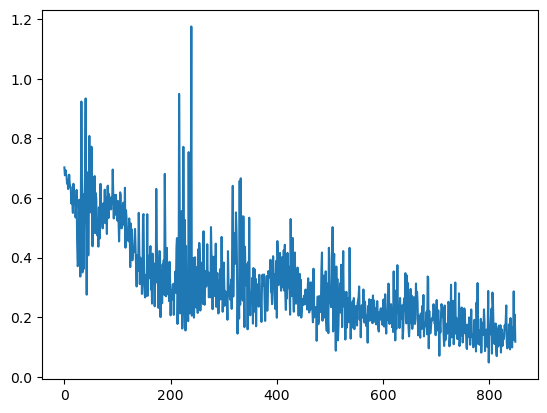

In [80]:
plt.plot(training_loss)

And predict:

In [83]:
def predict(model, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    predictions = []
    targets = []

    for x, y, sw in test_loader:
        x, y, sw = x.to(device), y.to(device), sw.to(device)
        outputs = model(x)
        predictions.append(F.softmax(outputs, dim=1))
        targets.append(y)
    
    return torch.cat(predictions).to('cpu'), torch.cat(targets).to('cpu')

In [85]:
predictions, targets = predict(lstm, test_dl)

In [87]:
cfm = metrics.confusion_matrix(targets, predictions.max(dim=1).indices)
print(f"The confusion matrix is:\n{cfm}")

The confusion matrix is:
[[372  37]
 [  8   5]]


In [89]:
recall = metrics.recall_score(targets, predictions.max(dim=1).indices)
print(f"The recall was {recall*100:.2f}%")

The recall was 38.46%


In [91]:
sensitivity = cfm[1,1]/cfm[1,:].sum()
print(f"The sensitivity is: {sensitivity*100:.2f}%")

The sensitivity is: 38.46%


In [93]:
specificity = cfm[0,0]/cfm[0,:].sum()
print(f"The specificity is: {specificity*100:.2f}%")

The specificity is: 90.95%
